I share a spotify playlist with a friend and I wanted to see if there were any patterns in the sound signals that could be visualized. I realized that since I already had  access to my own spotify data I might as well transform into a "cutting-edge" data scientist and plot everything! 

# Data Access:

You are going to need an access token to get into your juicy data. In order to to that you need a [Bearer Token](https://stackoverflow.com/a/25843058). I followed Spotify's [tutorial](https://developer.spotify.com/documentation/web-api/quick-start/) and had my token in short amount of time.

# Data Retrieval:

At this point I assume you have a Token and which you can paste below.

In [105]:
TOKEN = 'BQDaidc7-fYDCmHyvoyMlo5SqJ7l9NWBLzSigjoXrIKIgFPFPp-8Vk6p8y3rD9ZyMjX7CisAA3F52snCXSLLlniYrcQYB99ov1eOFFaak9h_lLlDHTo0TLB5WigUbL2Iwd1zPCONfrolnqP34JmSh4C2FsJMk0Do239AtnB7RnQWG5E_'

You can checkout all the [API endpoints](https://developer.spotify.com/documentation/web-api/reference-beta/) and see all Spotify has to offer. 

I wanted to analize songs so I chose the [Tracks](https://developer.spotify.com/documentation/web-api/reference/tracks/) endpoint. 

Note that tracks response and most endpoint responses for that matter are paginated. Some libraries can be composed of thousands of songs thefore a single request returning all the songs would impractical.

I just want to see how many songs are in my libary and fortunately we can access that field using the "total" key.

In [106]:
import json 
import requests

url = "https://api.spotify.com/v1/me/tracks"
headers = {'Authorization': "Bearer {}".format(TOKEN)}
r = requests.get(url, headers=headers)
tracks = json.loads(r.text)
song_count = tracks["total"]
print("Total number of songs: {}".format(song_count))

Total number of songs: 888


For some reason I felt like my library had more than 870 songs. Either way lets get specific track objects

### Gathering Track Data

Spotify returns a maximum of [50 songs](https://developer.spotify.com/documentation/web-api/reference/library/get-users-saved-tracks/) if you specify the limit.

In [107]:

from math import ceil

all_songs = []

for i in range(int(ceil(song_count/50.0))):
    offset = 50*i
    url = "https://api.spotify.com/v1/me/tracks?limit=50&offset={}".format(offset)
    headers = {'Authorization': "Bearer {}".format(TOKEN)}
    r = requests.get(url, headers=headers)
    tracks = json.loads(r.text)
    
    all_songs.extend(tracks["items"])
    
print("Number of gathered songs: {}".format(len(all_songs)))   

Number of gathered songs: 888


Awesome we have gathered all the tracks and can begin to dive into some data. 

Personally my goal was to observer wavelength patterns and get artsy with it. If this part sounds boring and you just want to plot other aspects of your spotify data keep scrolling.

Note that I am going to be changing urls because the goal of what I was doing was to compare my songs with my friends. My shared playlist is also 50 songs long. If I was working with my own library I would not do more than 50 songs.

The track object has an mp3 link that plays 30 seconds of each song. Im gonna download those mp3 files and convert them to wav files.

In [108]:
url = "https://api.spotify.com/v1/playlists/4zPScbIBFDKIKtCM3PvuJV"
headers = {'Authorization': "Bearer {}".format(TOKEN)}
r = requests.get(url, headers=headers)
tracks = json.loads(r.text)

I iterate through the songs and get the url link for all songs. I also saved the name of the person that added the song, along with the song name, and the filename.

The mp3 data is retrived and saved onto and mp3 file. I use [Pydub](https://github.com/jiaaro/pydub) to convert the data to a wav file.

There will be url links which are empty I chose to take not of that by calling the filename "NoFile" and downloading and empty file. I did this to skip the files latter own but I guess I could have kept a list of files with no mp3 and check against those later  im too lazy though.

In [10]:
# Ignore the silly file path 
import urllib.request
import scipy.io.wavfile
import pydub
SONG_FOLDER = '/home/lildreamz/Programming/jupyter_notebooks/spotifyAnalysis/songs/'
DATA_FOLDER = '/home/lildreamz/Programming/jupyter_notebooks/spotifyAnalysis/'
meta_data = []

songs = tracks['tracks']['items']

for song in songs:
    added_by = song['added_by']['id']
    name = song['track']['name']
    name = name.replace(" ", "")
    web_file = song['track']['preview_url']
    if web_file == None:
        meta_data.append({"add_by": added_by, "name": name, "filename": "NoFile"})
        continue
    
    filename = added_by + "_" + name 
    meta_data.append({"add_by": added_by, "name": name, "filename": filename})
    #print("Song name: %s. Was added by: %s.\nFILENAME: %s. link=%s\n"%(name, added_by, filename, web_file))
    # Download file
    data = urllib.request.urlretrieve(web_file,SONG_FOLDER + filename + ".mp3")
    mp3 = pydub.AudioSegment.from_mp3(SONG_FOLDER + filename + ".mp3")
    mp3.export(SONG_FOLDER + filename +".wav", format="wav")
    #print("rate: %r\n"%(rate))


# I am adding the following cell to hide tiffs name 

In [13]:
import numpy as np
meta_data = []

for song in songs:
    added_by = song['added_by']['id']
    if added_by == "tknoodle1":
        added_by = "friend"
    name = song['track']['name']
    name = name.replace(" ", "")
    web_file = song['track']['preview_url']
    if web_file == None:
        meta_data.append({"add_by": added_by, "name": name, "filename": "NoFile"})
        continue
    
    filename = added_by + "_" + name 
    meta_data.append({"add_by": added_by, "name": name, "filename": filename})
    #print("Song name: %s. Was added by: %s.\nFILENAME: %s. link=%s\n"%(name, added_by, filename, web_file))
    # Download file
    data = urllib.request.urlretrieve(web_file,SONG_FOLDER + filename + ".mp3")
    mp3 = pydub.AudioSegment.from_mp3(SONG_FOLDER + filename + ".mp3")
    mp3.export(SONG_FOLDER + filename +".wav", format="wav")
    #print("rate: %r\n"%(rate))
    

In [14]:
meta_data = np.array(meta_data)
np.save(DATA_FOLDER + "playlist_meta_data.npy", meta_data)

# End of cell that deletes tiffs name

Now that we have the .wav files saved lets see how these waves look. 

We can get the [sampling rate](https://manual.audacityteam.org/man/sample_rates.html) and audio wave data.

In [30]:
rate, data  = scipy.io.wavfile.read(SONG_FOLDER+"file.wav")

We can see if the audio is mono or stereo. In this case we have a stereo recording as we grab both channels.

In [32]:
data.shape[1]

2

In [33]:
chan_1 = data[:, 0]
chan_2 = data[:, 1]

The values of the audio data represent the amplitude of the wave. We can decompose the audio wave into different frequency wave using a [Fourier transform](https://betterexplained.com/articles/an-interactive-guide-to-the-fourier-transform/).

Text(0, 0.5, 'Amplitude')

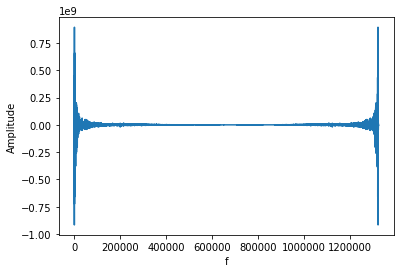

In [39]:
from numpy import fft as fft
import matplotlib.pyplot as plt
%matplotlib inline

fourier = fft.fft(chan_1)
plt.plot(fourier)
plt.xlabel('f')
plt.ylabel('Amplitude')


Im sure there are more things one can do with numpy or scipy and signals but I am grateful that [librosa](https://librosa.github.io/librosa/) exists. This library does all the heavy lifting of music and audio analyis. All I have to worry about is plotting.

Alright there are a few things happening here but you cant miss my skip NoFile "optimzation". First I load the file and get the data <strong>y</strong> and the sampling rate <strong>sr</strong> .

Then I seperate the [harmonic and percussive components](http://mir.ilsp.gr/harmonic_percussive_separation.html) of the audio.

I found the [Pitch Class](https://en.wikipedia.org/wiki/Pitch_class) as the coolest thing i could plot with little work. TL;DR A pitch is a specific note in a specific octave. However a pitch class is a specific note but any octave.

The last part is just seperating the chroma according to who added the song. Ultimatly the goal is to highlight differences or similarities between my friend's and my songs. 

In [44]:
import numpy as np

In [16]:
import librosa 

DATA_FOLDER = '/home/lildreamz/Programming/jupyter_notebooks/spotifyAnalysis/'

chromas = []
e_chromas = []
f_chromas = []
meta_data = np.load(DATA_FOLDER+"playlist_meta_data.npy")


for file in meta_data:    
    if file['filename'] == "NoFile":
        continue
    add_by = file['add_by']    
    filename = file['filename']+".wav"
    song_name = file['name']
    audio_path = SONG_FOLDER + filename
    # Load file
    y, sr = librosa.load(audio_path)
    # Split harmonics and percussives
    y_harmonic, _ = librosa.effects.hpss(y)
    C = librosa.feature.chroma_cqt(y=y_harmonic, sr=sr)
    if add_by == 'friend':
        f_chromas.append({"chroma": C, "sr": sr })
    elif add_by == 'earleag':
        e_chromas.append({"chroma": C, "sr": sr})
    chromas.append({"add_by": add_by, "chroma": C, "sr": sr, "name": song_name}) 

We can graph the chroma using the display module from librosa.

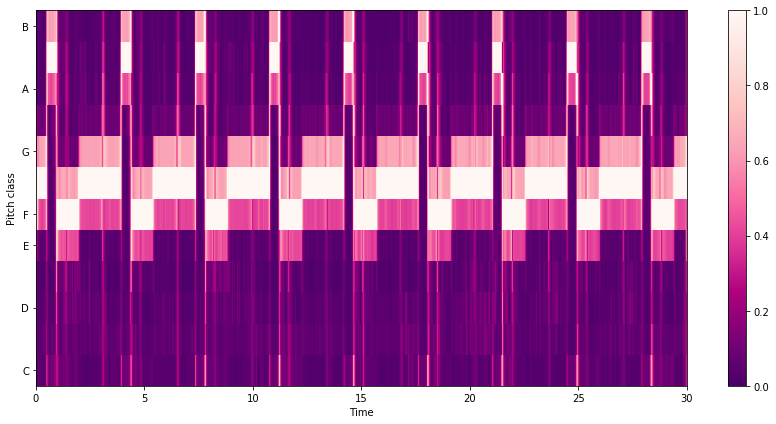

In [39]:
plt.figure(figsize=(12,6))
c = chromas[35]
librosa.display.specshow(c['chroma'], sr=c['sr'],
                         vmin=0, vmax=1, 
                         x_axis='time', y_axis='chroma',
                         cmap =  plt.get_cmap('RdPu_r'))
plt.colorbar()
plt.tight_layout()


I wanted to compare of a few of mine and my friend's chromas.  

Text(0, 0.5, '')

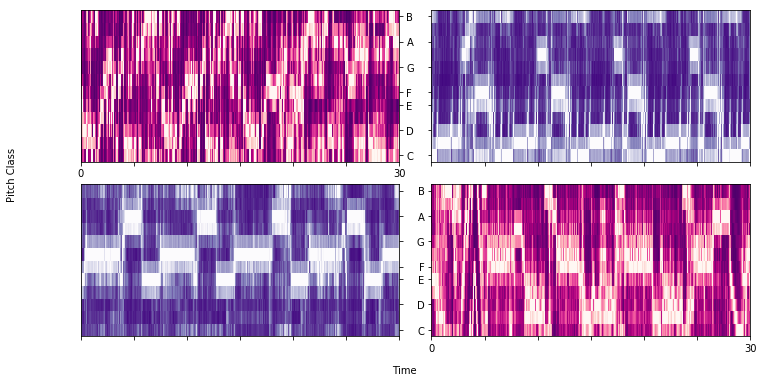

In [44]:

fig, ax = plt.subplots(nrows=3, ncols=3, sharex=True, sharey=True, figsize=(12, 6))
plt.subplots_adjust(hspace=0.15,wspace=0.1)
fig.text(0.5, 0.04, 'Time', ha='center')
fig.text(0.04, 0.5, 'Pitch Class', va='center', rotation='vertical')

ax1 = plt.subplot(2,2,1)
c = f_chromas[0]
librosa.display.specshow(c['chroma'], sr=c['sr'],
                         vmin=0, vmax=1, 
                         x_axis='time', y_axis='chroma',
                         cmap =  plt.get_cmap('RdPu_r'))
xticks = ax1.xaxis.get_major_ticks()
xticks[1].label1.set_visible(False)
xticks[2].label1.set_visible(False)
xticks[3].label1.set_visible(False)
xticks[4].label1.set_visible(False)
xticks[5].label1.set_visible(False)
ax1.set_xlabel("")
ax1.set_ylabel("")
ax1.yaxis.tick_right()

ax2 = plt.subplot(2,2,2)    
c = e_chromas[1]
librosa.display.specshow(c['chroma'], sr=c['sr'], 
                         x_axis='time', y_axis='chroma',
                               vmin=0, vmax=1,
                        cmap = plt.get_cmap('Purples_r'))


ax2.set_yticklabels([])
ax2.set_xticklabels([])
ax2.set_xlabel("")
ax2.set_ylabel("")

ax3 = plt.subplot(2,2,3)
c = f_chromas[1]
librosa.display.specshow(c['chroma'], sr=c['sr'], 
                         x_axis='time', y_axis='chroma',
                               vmin=0, vmax=1,
                        cmap = plt.get_cmap('Purples_r'))

ax3.set_yticklabels([])
ax3.set_xticklabels([])
ax3.set_xlabel("")
ax3.set_ylabel("")
ax3.yaxis.tick_right()



ax4 = plt.subplot(2,2,4)    
c = e_chromas[2]
librosa.display.specshow(c['chroma'], sr=c['sr'],
                         vmin=0, vmax=1, 
                         x_axis='time', y_axis='chroma',
                         cmap =  plt.get_cmap('RdPu_r'))


xticks = ax4.xaxis.get_major_ticks()
xticks[1].label1.set_visible(False)
xticks[2].label1.set_visible(False)
xticks[3].label1.set_visible(False)
xticks[4].label1.set_visible(False)
xticks[5].label1.set_visible(False)
ax4.set_xlabel("")
ax4.set_ylabel("")

Here are all the tracks displayed side by side

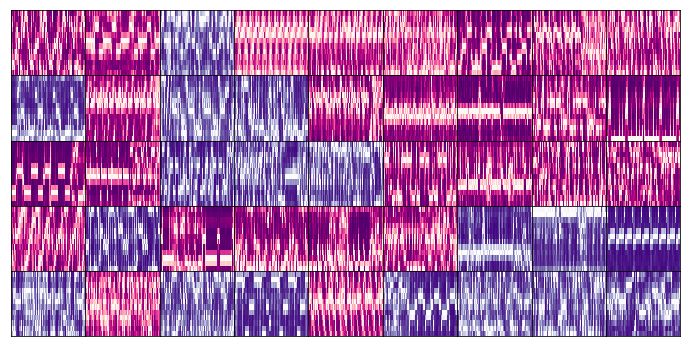

In [26]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import librosa.display

from palettable.colorbrewer.sequential import GnBu_9_r
from palettable.matplotlib import Viridis_3
from palettable.cartocolors.sequential import Sunset_7_r

plt.figure(figsize=(12,6))
gs1 = gridspec.GridSpec(5, 9)
gs1.update(wspace=0.0, hspace=0.0)
gs_ix = 0

for chroma in chromas:
    plt.subplot(gs1[gs_ix])
    
    gs_ix = gs_ix + 1    
    #if chroma['name'] == 'Dreganomics' or chroma['name'] == 'Casio' or chroma['name'] == 'Fades' or chroma['name'] == 'Look@Ugo':
    #    librosa.display.specshow(chroma['chroma'], sr=chroma['sr'], 
    #                             vmin=0, vmax=1,  
    #                             cmap = plt.get_cmap('YlGnBu_r'))
    if chroma['add_by'] == 'friend':
        librosa.display.specshow(chroma['chroma'], 
                                sr=chroma['sr'], 
                               vmin=0, vmax=1,  
                              cmap = plt.get_cmap('RdPu_r'))
    elif chroma['add_by'] == 'earleag':        
        librosa.display.specshow(chroma['chroma'], 
                                 sr=chroma['sr'], 
                                 vmin=0, vmax=1,  
                                 cmap = plt.get_cmap('Purples_r'))


Alright well that does it for sound wave analysis. 

The [song features](https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/) end point has a lot of cool info like the "danceability" of a song or the "energy" among others. 

A bunch of questions come to mind, but some that I want to answer based on these features are:

Is my playlist composed of danceable songs?
Do I prefer high energy songs or low energy songs?

How has my song taste changed?

Are there genres that I prefer and can I see if my taste in genres has also changed?


In order to get song features we need to know which particular song we are requesting. So im just gonna collect the id's in each track object. Requesting song features is the same process as requesting tracks the only difference is the url.

In [109]:
song_ids = []

for song in all_songs:
    _id = song['track']['id']
    song_ids.append(_id)
print("Number of ids gathered: {}".format(len(all_songs)))    

Number of ids gathered: 888


In [110]:
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry
song_features_by_id = {}

s = requests.Session()
retries = Retry(total=300, backoff_factor=1, 
                status_forcelist=[502,503,504,429])
s.mount('https://', HTTPAdapter(max_retries=retries))

for song_id in song_ids:
    url = "https://api.spotify.com/v1/audio-features/{}".format(song_id)
    headers = {'Authorization': "Bearer {}".format(TOKEN)}
    r = s.get(url, headers=headers)
    
    parsed = json.loads(r.text)
    
    song_info = parsed

    
    try:
        a = song_info["type"]
    except:
        print(parsed)
        
    song_features_by_id[song_id] = song_info

In [111]:
# Seeing how the song feature JSON looks
song_features_by_id[song_ids[0]]

{'danceability': 0.958,
 'energy': 0.77,
 'key': 9,
 'loudness': -8.047,
 'mode': 0,
 'speechiness': 0.0843,
 'acousticness': 0.166,
 'instrumentalness': 0.0626,
 'liveness': 0.0553,
 'valence': 0.94,
 'tempo': 117.98,
 'type': 'audio_features',
 'id': '2n2C5eahczWXA8mY08TqgR',
 'uri': 'spotify:track:2n2C5eahczWXA8mY08TqgR',
 'track_href': 'https://api.spotify.com/v1/tracks/2n2C5eahczWXA8mY08TqgR',
 'analysis_url': 'https://api.spotify.com/v1/audio-analysis/2n2C5eahczWXA8mY08TqgR',
 'duration_ms': 296680,
 'time_signature': 4}

I decided to focus on Danceability, energy, acousticness, valence, speechines, and Liveness.

My observations based on the graphs:
    
**Danceability**: describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity

* normally distributed and my playlist is composed of songs that are in between being danceable and least danceaable.

**Energy**: measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity.

* The energy in my playlist is slightly right skewed which means my playlist is more energetic.

**Valence**: A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track.

* Valence is a normal distribution but it has heavy tails. It isn't uniformly distributed but without the kernel surrounding the histogram it would seem like it is a uniform distribution. Regardless this seems to indicate that my playlist is composed of happy, cheerful, euphoric songs as much as sad, depressed, and angry songs.


**Speechiness**: Speechiness detects the presence of spoken words in a track

* This was actually a surprise. I thought that my playlist would have equal amounts of tracks with speech and instrumental. This plot indicates that most of my playlist is made up of instrumental  



**liveness**: Detects the presence of an audience in the recording. 

* I know most of the songs in my playlist are not "live" tracks. This plot is showing just that, my playlist is skewed towards recorded songs. 

This was all very insightful but now I wanted to break it up by year and see if these values have been consistent throught the years or if they have changed.

Text(0.5, 1.0, 'Liveness')

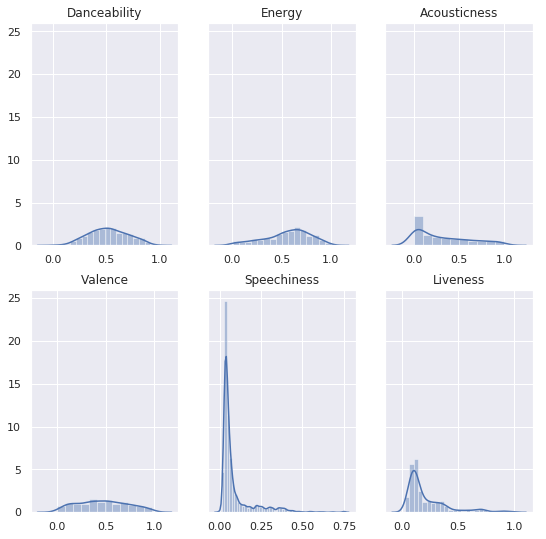

In [112]:
import seaborn as sns


danceability =  []
energy = []
acousticness = []
valence = []
speechiness = []
liveness = []    

for song_id in song_features_by_id:
    d = song_features_by_id[song_id]['danceability']
    e = song_features_by_id[song_id]['energy']
    a = song_features_by_id[song_id]['acousticness']
    v = song_features_by_id[song_id]['valence']
    s = song_features_by_id[song_id]['speechiness']
    l = song_features_by_id[song_id]['liveness']
    speechiness.append(s)
    valence.append(v)
    acousticness.append(a)    
    energy.append(e)
    danceability.append(d)
    liveness.append(l)

sns.set(color_codes=True)
f, axes = plt.subplots(2, 3, figsize=(9,9), sharey=True)   


ax = sns.distplot(danceability, ax=axes[0,0])
ax.set_title("Danceability")

ax = sns.distplot(energy, ax=axes[0,1])
ax.set_title("Energy")

ax = sns.distplot(acousticness, ax=axes[0,2])
ax.set_title("Acousticness")

ax = sns.distplot(valence, ax=axes[1,0])
ax.set_title("Valence")

ax = sns.distplot(speechiness, ax=axes[1,1])
ax.set_title("Speechiness")

ax = sns.distplot(liveness, ax=axes[1,2])
ax.set_title("Liveness")

In [113]:
import pandas as pd

song_features_df = pd.DataFrame(
    { 'Danceability': danceability,
      'Energy': energy,
      'Acousticness': acousticness,
      'Valence': valence,
      'Speechiness': speechiness,
      'liveness': liveness
    })


The histograms were insighful but I wanted to create boxplots before I moved on for completeness.

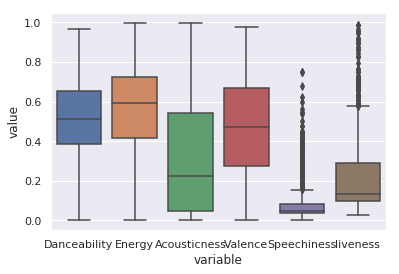

In [114]:
sns.boxplot(x="variable", y="value", data=pd.melt(song_features_df))

In order to separate by year I needed the date the song was added in my playlist. The tracks object has a field to find the add date of each song into your library. I use python timestamp functionality to strip everything but the year. 

In [115]:
song_add_date = []

for song in all_songs:
    timestamp = song['added_at']
    song_add_date.append(timestamp)

In [116]:
from datetime import datetime

song_timestamp = [datetime.strptime(date, '%Y-%m-%dT%H:%M:%SZ').date() for date in song_add_date]

In [117]:
song_features_df = song_features_df.assign(Timestamp=song_timestamp)
song_features_df['Timestamp'] = pd.to_datetime(song_features_df['Timestamp']) 

I decided to choose a [boxplot](https://towardsdatascience.com/understanding-boxplots-5e2df7bcbd51) because i dont care about the shape of the distribution but where the distributions lie in regards to one another.  

Excluding acousticness it seems that for the other categories there has been an increase in value. I have found myself listening to more EDM lately so that makes sense. 

Im not sure how to interpret those outliers in speechiness. Are the songs in my library so predominantly instrumentals that a song with a "regular" amount of words has a large effect on my data? Values close to 1 are similar to (audio books, podcasts, poetry)  I know i dont have audio books or podcasts on spotify they could be rap songs. Im rambling.

Similarily for liveleness. I don't have live songs so I wonder what sounds in those songs are making them sound like they are live.

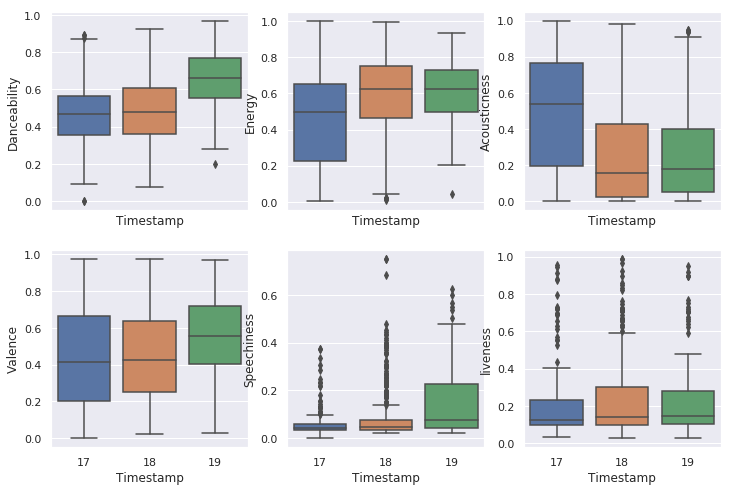

In [118]:
years = song_features_df.Timestamp.apply(lambda x: x.strftime('%y'))

sns.set(color_codes=True)
f, axes = plt.subplots(2, 3, figsize=(12,8), sharex=True)

ax = sns.boxplot(years, song_features_df.Danceability,ax=axes[0,0])

ax = sns.boxplot(years, song_features_df.Energy,ax=axes[0,1])

ax = sns.boxplot(years, song_features_df.Acousticness,ax=axes[0,2])

ax = sns.boxplot(years, song_features_df.Valence,ax=axes[1,0])

ax = sns.boxplot(years, song_features_df.Speechiness,ax=axes[1,1])

ax = sns.boxplot(years, song_features_df.liveness,ax=axes[1,2])

I wanted to see if I could visualize the genres in my library I did not want to use a barplot. 

First step was getting genres unfortunately you [cannot get song or album genres](https://github.com/spotify/web-api/issues/1100) the next best thing is to get  the artist genres. 

Obviously this might not be a good way to represent song genres, but I feel like most artists within a small number of genres.

Alright first thing is to get the artist id's we will need these to request the artist objects which contain the genres and then assign these genres to songs by associating them with artist ids 

In [119]:
artist_ids = set()

for song in all_songs:
    artists = song['track']['artists']
    for artist in artists:
        artist_ids.add(artist['id'])
    
print("Number of artists: {}".format(len(artist_ids)))    

Number of artists: 278


In [120]:
artist_info_by_id = {}

s = requests.Session()
retries = Retry(total=3000, backoff_factor=1, status_forcelist=[ 502, 503, 504, 429 ])
s.mount('https://', HTTPAdapter(max_retries=retries))

for artist_id in artist_ids:
    url = "https://api.spotify.com/v1/artists/{}".format(artist_id)
    headers = {'Authorization': "Bearer {}".format(TOKEN)}
    r = s.get(url, headers=headers)

    #TODO: check for error apart from dumb retries?

    parsed = json.loads(r.text)    

    artist_info = parsed

    #TODO: sanity checks?
    try:
        a = artist_info["genres"]
    except:
        print("Entry seems wrong. Fix it:")
        print(artist_info)
        break

    artist_info_by_id[artist_id] = artist_info

Unfortuntaly the song genres will get more deviated from the artist genres. Some songs features more than one artist I got lazy and appeneded those genres as well. 

In [121]:
song_genres_based_on_artist = []
for song in all_songs:
    genres = []
    artists = song['track']['artists']
    for artist in artists:
        _id = artist['id']
        genres.extend(artist_info_by_id[_id]['genres'])
    
    song_genres_based_on_artist.append(genres) 

I've seen [Sankey diagrams](https://en.wikipedia.org/wiki/Sankey_diagram) on Reddit, they look pretty cool imo. I felt that showing flow from genres to years would be a cool way to display how my taste in genres has changed over the years and if this would help explain some of the variation in the boxplots.

I used [ipysanketwidget](https://nbviewer.jupyter.org/github/ricklupton/ipysankeywidget/blob/master/examples/Simple%20example.ipynb) to create the diagram. I need to transform my data to have a source, target, value, and type.

In this case I want the source to be the genres and the target to be the year. The value will be the count of genres by year and the type will be the genre itself.

In [197]:
song_timestamps = song_features_df.Timestamp

song_genres =  pd.DataFrame(
    {
        'artist_genres': song_genres_based_on_artist,
        'add_date': song_timestamps,
})

# Remove NANs and empty song genres.
song_genres = song_genres.dropna()
song_genres = song_genres[(song_genres.astype(str)['artist_genres'] != '[]')].reset_index()
song_genres = song_genres.drop(['index'], axis=1)

The function reduce genres does a lot of things in three lines and the best way to understand it is to see what it does to a small data frame on each line. 

In [198]:
def reduce_genres(gen):
    # Replace characters outside of the values within the brackets
    # with white spaces. Convertt uppercase to lowercase and 
    # split the string in to an array.
    genre = re.sub("[^a-zA-Z0-9&]"," ",str(gen)).lower().split()
    # The second line goes through arrays and removes any 
    # stopwords (https://www.geeksforgeeks.org/removing-stop-words-nltk-python/).
    genre = [i for i in genre if i not in set(stopwords.words("english"))]
    # We use scipy stats.mode (https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mode.html) 
    # to extract the most common word (genre) in each array
    mode1 = str(stats.mode(genre)).split('[')[1].split(']')[0]
    return mode1
    

In [199]:
song_genres['genres'] = song_genres['artist_genres'].apply(lambda x: reduce_genres(x))

In [200]:
song_genres['year'] = [x.year for x in song_genres['add_date']]

In [201]:
song_genres  = song_genres.drop(['artist_genres', 'add_date'], axis=1)

In [202]:
song_genres.head()

,genres,year
0,'indie',2019
1,'rap',2019
2,'rock',2019
3,'alternative',2019
4,'twitch',2019


In [203]:
song_genres = song_genres.groupby(['genres', 'year']).size().reset_index(name='counts')

In [204]:
song_genres.columns = ['source', 'target', 'value']                                                                                                                                                  
song_genres['type'] = song_genres['source'] 

There we have it its actually much cooler than I thought it would look.

In [217]:
from ipysankeywidget import SankeyWidget               
from ipywidgets import Layout

layout = Layout(width="900", height="1000")
sankey = SankeyWidget(links=song_genres.to_dict('records'), layout=layout,
                      linkLabelFormat='.1f',
                     link_color=plt.get_cmap('tab20b'))
sankey

SankeyWidget(layout=Layout(height='1000', width='900'), linkLabelFormat='.1f', links=[{'source': "'afrobeat'",…

In [218]:
sankey.save_png('mysankey.png')

That is all for this section there is so much that could be done from this point on. In my case I wanted to explore how the data looked and what I could learn from it by vizualing it. My goal is to write my own recommender based off of all my data and I think that going through the exploratory phase gave me so much to work with. I can build the system using song features as well as using the decompossed sound signals. 